# Geometric Median
## L2 Mean in $\mathbb{R}^N$
The L2 mean in $\mathbb{R}^N$ is simply the average of the coordinates of the points.

def l2_mean()

## L1 Mean 
### In $\mathbb{R}^N$
Sources :
- Paper
- [Wikipedia](https://en.wikipedia.org/wiki/Geometric_median])


The $L_1$ mean of a set of points $x_i$  in some metric space is the point $\bar x$ that minimizes the sum of distances to the points. In practice, it corresponds to the median.
Thus, 
$$ \bar x = argmin \sum_{i=1}^{n}d(x, x_i) $$

Compared to the $L_2$ norm, there is no known explicit formula for the $L_1$ norm. There are however iterative procedures, making use of the fact that the sum of the distances to the samples points is a convex function, since the distance to each function point is convex, and therefore their sum is convex.

One common approach of this type, called Weiszfeld's algorithm is a form of iteratively re-weighted least squares. his algorithm defines a set of weights that are inversely proportional to the distances from the current estimate to the sample points, and creates a new estimate that is the weighted average of the sample according to these weights. 

### Weiszfeld's algorithm
The $L_1$ mean of a set of points in $\mathbb{R}^N$ may be written as the point $\bar x$ that minimizes the cost function

$$
C(y) = \sum_{i=1}^{n}||y-x_i||
$$

As we saw, $C(y)$ is convex, so we know a gradient descent approach is guaranteed to converge. The gradient of the cost function is

$$
\nabla_C = - \sum_{i=1}^{n} \frac{x_i - y}{||x_i - y||}
$$

In other words, $\nabla_C$ is the sum of the unit vectors directed from $y$ to each of the points $x_i$.

Given a current estimate $y^t$, the iteration step is thus

$$
y^{t+1} = y^{t} + \lambda \sum_{i=1}^{n} \frac{x_i - y^t}{||x_i - y^t||}
$$

Where $\lambda > 0$, which  is proposed to be $\lambda = \lambda \sum_{i=1}^{n} ||x_i - y^t||$.

The iteration step becomes:

$$
y^{t+1} = \frac{\sum_{i=1}^{n} \frac{x_i}{||x_i - y^t||}}{\sum_{i=1}^{n} \frac{1}{||x_i - y^t||}}
$$

As long as the intermediate iterates $y_i^t$ do not coincide with any of the points $x_i$, this algorithm will provably converge. If it gets stuck, a strategy is to displace the iterate $y^t$ slightly and continue.



In [13]:
import numpy as np
def Weiszfeld(elements: list):
    # Temporarily, we initialize with a random value
    # TODO provide an "average" function for initialization
    y = np.random.rand(*elements[0].shape)
    # TODO define convergence
    for _ in range(100):
        numerator = 0
        denumerator = 0
        for xi in elements:
            if np.array_equal(xi, y):
                y += np.random.rand(*y.shape) * 1e-6
            X = np.linalg.norm(xi - y)
            numerator += xi / X
            denumerator += 1 / X
        y = numerator / denumerator
    return y

def test_Weiszfeld():
    random_r3 = np.random.rand(10, 3)
    random_r3[:6] = [2,2,2]
    print(random_r3)
    return Weiszfeld(random_r3)

test_Weiszfeld()

[[2.         2.         2.        ]
 [2.         2.         2.        ]
 [2.         2.         2.        ]
 [2.         2.         2.        ]
 [2.         2.         2.        ]
 [2.         2.         2.        ]
 [0.09575071 0.77315759 0.62486106]
 [0.0785391  0.647403   0.07316702]
 [0.13113394 0.09806928 0.75533388]
 [0.42840262 0.34733753 0.64845221]]


array([2., 2., 2.])

## Testing the median
### Verfiy that the median is correctly computed
Method: produce a constant signal in $\mathbb{R}^N$ and add noise to it. As long as we have less than 50% of noise, regardless of its value, the median should return the constant.

/tmp/ipykernel_565570/172967782.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


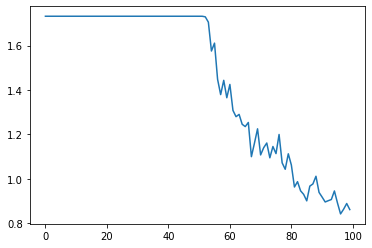

In [30]:
import numpy as np

def test_robustness(percent_noisy):
    """
    percent_noisy: float in [0, 1]
    """
    signal_length = 100
    N = 3
    noise_length = int(percent_noisy * signal_length)

    signal = np.ones((signal_length, N))
    noise = np.random.rand(noise_length, N)
    signal[:noise_length] = noise
    np.random.shuffle(signal)
    return Weiszfeld(signal)


medians = []
for pn in np.arange(0, 1, 0.01):
    medians.append(test_robustness(pn))
medians = np.array(medians)


import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot([x for x in range(medians.shape[0])], np.linalg.norm(medians, axis=1))
fig.show()


### In S03
We are now interested in computing the L1 geometric mean in the group of rotations SO(3), and we call it the geodesic median.
To be able to apply the Weiszfeld algorithm, we need to transition back and forth between the rotation manifold and its tangent space at centered at the current estimate.

#### Defining the mappings
##### Exponential map $\mathbb{R}^N$ to SO3
Consider a rotation $R$ in its axis-angle representation $v = \theta \hat v$. Writing $[v]_\times$ to be the $3 \times 3$ skew-symetric matrix corresponding to $v$, we have $R = exp([v]_\times)$.

In [9]:
def skew(v):
    return [
        [0, -v[2], v[1]], 
        [v[2], 0, -v[0],
        [-v[1], v[0], 0]]
        ]

def vee(W):
    return [-W[1][2], W[0][2], -W[0][1]]

def R3_to_S03(v):
    """
    aka exponential map (TODO confirm)
    v is an axis-angle
    """
    #return base.transforms3d.exp2r(v)
    return SO3.Exp(v)

R3_to_S03([3.14, 0, 0])

NameError: name 'SO3' is not defined

In [ ]:
def SO3_to_R3(R, S):
    """
    log map centered in S
    matrix to axis angle
    """
    v_skew = (R * S.inv()).log()
    return vee(v_skew)
    
R = SO3.Rx(0.3)
S = SO3.Rx(0.1)
w = SO3_to_R3(R, S)
w


[0.2, 0.0, -0.0]

In [ ]:
SO3_to_R3(R3_to_S03(w), SO3())

[0.2, 0.0, -0.0]

In [ ]:
# Create a rotation matrix and get its axis-angle
from spatialmath import SO3, base
R = base.transforms3d.angvec2r(15, [1.0,0,0])
base.transforms3d.tr2angvec(R)

(2.433629385640827, array([1., 0., 0.]))

In [ ]:
x = SO3.Rx(0.3)
s = SO3.Rx(0.1)
v_skew = (x * s.inv()).log() # Log centered in S
SO3.Exp(v_skew) # Exp
# 

   1         0         0         
   0         0.9801   -0.1987    
   0         0.1987    0.9801    
